In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(140)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.1:44424 Dashboard: http://172.30.100.1:46617/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

133


In [4]:
import sys
import os
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob
import dask.array as da


%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
#params

plot_dzU_profiles=True


In [10]:
config='EU36'
case='MPC001'
freq='1d'
year='2012'

list_month=['m03','m09']

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
if config == 'EU36':
    gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
    maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'
if config == 'GS36':
    gridfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36_coordinates.nc'
    maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'


In [7]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.core - ERROR - 'tcp://172.30.9.106:41810'
Traceback (most recent call last):
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/core.py", line 412, in handle_comm
    result = yield result
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/scheduler.py", line 1500, in add_worker
    yield self.handle_worker(comm=comm, worker=address)
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 735, in run
    value = future.result()
  File "/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
  

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

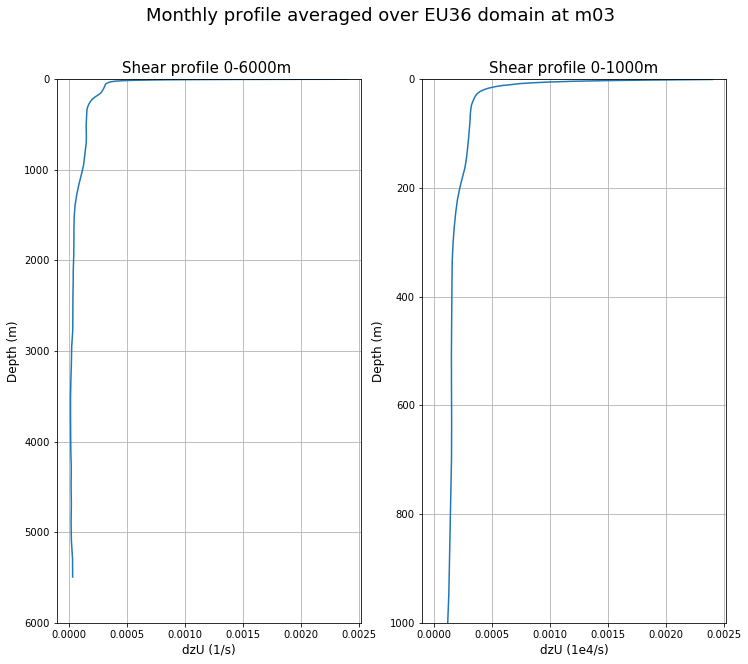

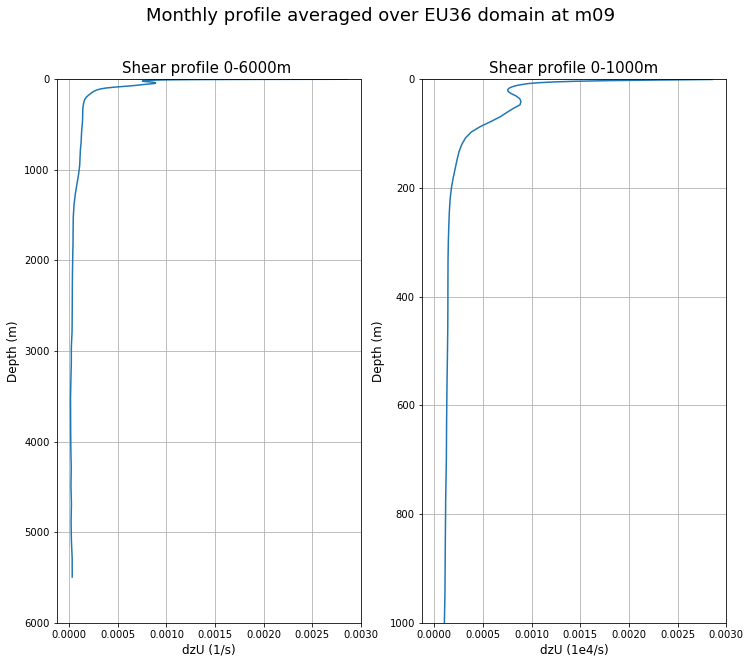

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


In [11]:
if plot_dzU_profiles==True:
    for m in list_month:
        filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+str(m)+'d??.'+str(freq)+'_gridU.nc'))
        filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+str(m)+'d??.'+str(freq)+'_gridV.nc'))
        dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
        dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
        u=dsU.vozocrtx
        v=dsV.vomecrty
        u_anom=u-u.mean(dim='time_counter')
        v_anom=v-v.mean(dim='time_counter')
        e3u=dsmask.e3u_0
        e3v=dsmask.e3v_0
        e3u_d=e3u.rename({'nav_lev':'depthu'})
        e3v_d=e3v.rename({'nav_lev':'depthv'})
        dz_u = (u_anom.shift(depthu=-1) - u_anom)
        dz_v = (v_anom.shift(depthv=-1) - v_anom)
        inv_e3u_d=1/e3u_d
        inv_e3v_d=1/e3v_d
        dask_inv_e3u=da.from_array(inv_e3u_d, chunks=(1, 1, 1000, 700))
        dask_inv_e3v=da.from_array(inv_e3v_d, chunks=(1, 1, 1000, 700))
        udz=dz_u*dask_inv_e3u
        vdz=dz_v*dask_inv_e3v
        udz2=udz*udz
        vdz2=vdz*vdz
        udz2_t=udz2.rename({'depthu':'deptht'})
        vdz2_t=vdz2.rename({'depthv':'deptht'})
        udz2vdz2sum=udz2_t+vdz2_t
        shear=np.sqrt(udz2vdz2sum)
        fig, axes = plt.subplots(1,2,figsize=(12,10))
        axes = axes.ravel()
        ax=axes[0]
        shear.mean(dim='time_counter').mean(dim='x').mean(dim='y').plot(y='deptht', yincrease=False,ax=ax)
        ax.set_ylim(6000,0)
        ax.set_ylabel('Depth (m)',fontsize=12)
        ax.set_xlabel('dzU (1/s)',fontsize=12)
        ax.grid()
        ax.set_title('Shear profile 0-6000m ',fontsize=15)
        ax=axes[1]
        shear.mean(dim='time_counter').mean(dim='x').mean(dim='y').plot(y='deptht', yincrease=False,ax=ax)
        ax.set_ylim(1000,0)
        ax.set_ylabel('Depth (m)',fontsize=12)
        ax.set_xlabel('dzU (1e4/s)',fontsize=12)
        ax.grid()
        ax.set_title('Shear profile 0-1000m',fontsize=15)
        fig.suptitle('Monthly profile averaged over '+config+' domain at '+str(m), fontsize=18)
        plt.savefig('Plots/'+config+'/Profiles/'+config+'-'+case+'y'+str(year)+str(m)+'_mean-shear-profile.png')